In [1]:
%load_ext autoreload
%autoreload 2

### Evaluation methodology
To evaluate our model's robustness to adversarial attacks, we'll perform black-box attacks on it using gra. We hope to use the transferability properties and make our model less prone to black-box attacks.  
- adversarial objective function based on the fast gradient sign method regularization
- adversarial training: injecting adversarial examples in training

### Load the data

In [2]:
import pathlib
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import PIL
import os

# TODO: add any imports you use here

from torch import nn

from utils.train_model import train_model, plot_stats

In [3]:
# Create a pytorch dataset
data_dir = pathlib.Path('data/tiny-imagenet-200')
CLASS_NAMES = np.array([item.name for item in (data_dir / 'train').glob('*') if os.path.isdir(item.__str__())])

### Data Augmentation

In [4]:
# TODO: Add more tranforms
# E.g. Crop random 56x56 patches
# Add more transforms relevant to our augmentation technique
# https://pytorch.org/docs/stable/torchvision/transforms.html

transforms_to_compose = [transforms.Resize((224, 224)),
                         transforms.ToTensor(),
                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]

In [5]:
# Create the training data generator
batch_size = 32
data_transforms = {x: transforms.Compose(transforms_to_compose) for x in ['train', 'val']}
datasets = {x: torchvision.datasets.ImageFolder(data_dir / x, data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True) for x in ['train', 'val']}

print("Training set size: ", len(datasets['train']))
print("Validation set size: ", len(datasets['val']))

Training set size:  100000
Validation set size:  10000


### Create the model and train
First, we need to establish a baseline error that our model makes without adversarial training. Per transferability, we should be able to fool our net with data trained on a different architecture. 

In [6]:
from torchvision.models import resnet18

class TargetNet(nn.Module):
    def __init__(self, num_classes):
        super(TargetNet, self).__init__()
        self.model = resnet18(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        return self.model.forward(x)

In [7]:
from torchvision.models import densenet121

class SourceNet(nn.Module):
    def __init__(self, num_classes):
        super(SourceNet, self).__init__()
        self.model = densenet121(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.classifier = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        return self.model.forward(x)

In [8]:
target_net = TargetNet(len(CLASS_NAMES))
target_net.load_state_dict(torch.load('models/baseline.pt'))

<All keys matched successfully>

In [9]:
# Model has already been trained so no need to re-run
# source_net = SourceNet(len(CLASS_NAMES))
# source_params_to_update = [param for param in source_net.parameters() if param.requires_grad]
# source_optim = torch.optim.Adam(source_params_to_update)
# source_criterion = nn.CrossEntropyLoss()

In [10]:
# source_net, source_stats = train_model(source_net, dataloaders, source_criterion, source_optim, 'models/adv-source-plain.pt', 5)

In [11]:
source_net = SourceNet(len(CLASS_NAMES))
source_net.load_state_dict(torch.load('models/adv-source-plain.pt'))

<All keys matched successfully>

In [12]:
def fgsm(img, eps, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_img = img + eps*sign_data_grad
    return perturbed_img

In [13]:
import torch.nn.functional as F

def test_attack(target_model, source_model, val_data, epsilon=0.2, attack=fgsm):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion_class = nn.CrossEntropyLoss()
    target_model = target_model.to(device)
    source_model = source_model.to(device)
    running_corrects = 0.0
    for inputs, labels in val_data:
        source_model.zero_grad()
        target_model.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs.requires_grad = True
        target_outputs = target_model(inputs)
        _, initial_preds = torch.max(target_outputs, 1)
        # calculate gradient on source network
        source_outputs = source_model(inputs)
        loss = F.nll_loss(source_outputs, labels)
        loss.backward()
        data_grad = inputs.grad.data
        # add perturbation to data
        inputs_adv = attack(inputs, epsilon, data_grad)
        # get predictions from target network
        target_outputs = target_model(inputs_adv)
        _, final_preds = torch.max(target_outputs, 1)
        running_corrects += torch.sum(final_preds == labels.data)
        # get some examples to inspect
        # print(torch.cuda.memory_allocated("cuda:0"))
    acc = running_corrects.double() / len(val_data.dataset)
    return acc

In [14]:
eps_vals = np.arange(0, 0.5, 0.1)

In [15]:
acc_plain = []
for eps in eps_vals:
    acc_plain.append(test_attack(target_net, source_net, dataloaders['val'], epsilon=eps))

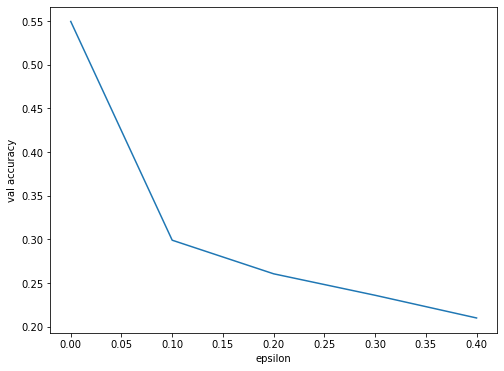

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(eps_vals, np.array(acc_plain))
plt.xlabel('epsilon')
plt.ylabel('val accuracy')
plt.show()

In [18]:
acc_plain

[tensor(0.5497, device='cuda:0', dtype=torch.float64),
 tensor(0.2991, device='cuda:0', dtype=torch.float64),
 tensor(0.2606, device='cuda:0', dtype=torch.float64),
 tensor(0.2360, device='cuda:0', dtype=torch.float64),
 tensor(0.2100, device='cuda:0', dtype=torch.float64)]

### Adversarial Objective Function
We change the objective function as explained in [EXPLAINING AND HARNESSING
ADVERSARIAL EXAMPLES](https://arxiv.org/pdf/1412.6572.pdf).

In [17]:
import torch.nn.functional as F
import time
import copy

def train_model_adv_obj(model, dataloaders, criterion, optimizer, model_file, alpha=0.5, epsilon=0.2, num_epochs=10):
    """
    Modified version of https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
    """
    since = time.time()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                inputs.requires_grad = True
                
                # zero gradient before calculating inputs grad
                model.zero_grad()
                
                outputs = model(inputs)
                loss = F.nll_loss(outputs, labels)
                loss.backward(retain_graph=True)
                
                data_grad = inputs.grad.data
                inputs_adv = fgsm(inputs, epsilon, data_grad)
                outputs_adv = model(inputs_adv)
                
                # zero gradient before optmizing
                optimizer.zero_grad()
                
                total_loss = alpha * criterion(outputs, labels) + (1 - alpha) * criterion(outputs_adv, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    total_loss.backward()
                    optimizer.step()

                running_loss += total_loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load and save best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), model_file)
    
    stats = (train_acc_history, train_loss_history, val_acc_history, val_loss_history)
    return model, stats

In [22]:
# target_net_adv_obj = TargetNet(len(CLASS_NAMES))
# target_params_to_update = [param for param in target_net_adv_obj.parameters() if param.requires_grad]
# target_optim = torch.optim.Adam(target_params_to_update)
# target_criterion = nn.CrossEntropyLoss()

In [23]:
# target_net_adv_obj, _ = train_model_adv_obj(target_net_adv_obj, dataloaders, target_criterion, target_optim, 'models/adv-target-adv-obj.pt', num_epochs=5)

Epoch 0/4
----------
train Loss: 4.1490 Acc: 0.4010
val Loss: 4.1027 Acc: 0.2335

Epoch 1/4
----------
train Loss: 3.8277 Acc: 0.4946
val Loss: 4.1118 Acc: 0.2218

Epoch 2/4
----------
train Loss: 3.7774 Acc: 0.5064
val Loss: 4.0604 Acc: 0.2312

Epoch 3/4
----------
train Loss: 3.7482 Acc: 0.5150
val Loss: 4.0209 Acc: 0.2402

Epoch 4/4
----------
train Loss: 3.7337 Acc: 0.5171
val Loss: 3.9923 Acc: 0.2396

Training complete in 159m 19s
Best val Acc: 0.240200


In [19]:
target_net_adv_obj = TargetNet(len(CLASS_NAMES))
target_net_adv_obj.load_state_dict(torch.load('models/adv-target-adv-obj.pt'))

<All keys matched successfully>

In [20]:
acc_adv_obj = []
for eps in eps_vals:
    acc_adv_obj.append(test_attack(target_net_adv_obj, source_net, dataloaders['val'], epsilon=eps))

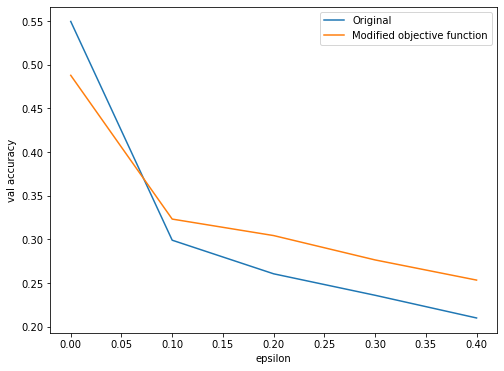

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(eps_vals, np.array(acc_plain), label='Original')
plt.plot(eps_vals, np.array(acc_adv_obj), label='Modified objective function')
plt.xlabel('epsilon')
plt.ylabel('val accuracy')
plt.legend()
plt.show()

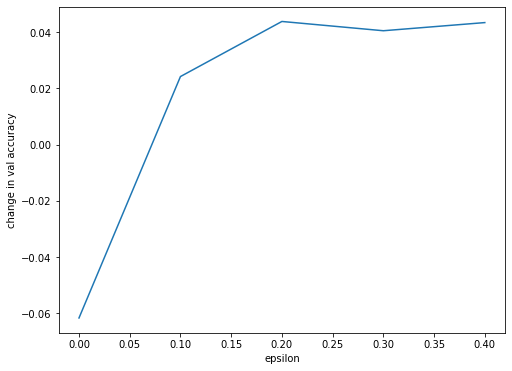

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(eps_vals, np.array(acc_adv_obj, dtype=np.float32) - np.array(acc_plain, dtype=np.float32))
plt.xlabel('epsilon')
plt.ylabel('change in val accuracy')
plt.show()

While we sacrifice some accuracy on original images, the accuracy on the adversarial examples improved by 5-10%. Epsilon is hyperparameter that scales added noise so a higher epsilon equals a stronger adversary.

### Train the model using gradients from multiple models

### Train more parameters including convolutional layers.

In [29]:
class TargetNetConv(nn.Module):
    def __init__(self, num_classes):
        super(TargetNetConv, self).__init__()
        self.model = resnet18(pretrained=True)
        for param in list(self.model.parameters())[:-15]:
            param.requires_grad = False
        self.model.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        return self.model.forward(x)

In [30]:
target_net_adv_obj_conv = TargetNetConv(len(CLASS_NAMES))
target_params_to_update = [param for param in target_net_adv_obj_conv.parameters() if param.requires_grad]
target_optim = torch.optim.Adam(target_params_to_update)
target_criterion = nn.CrossEntropyLoss()

In [31]:
target_net_adv_obj_conv, _ = train_model_adv_obj(target_net_adv_obj_conv, dataloaders, target_criterion, target_optim, 'models/adv-target-adv-obj-conv.pt', num_epochs=5)

Epoch 0/4
----------
train Loss: 3.4150 Acc: 0.3942
val Loss: 4.6216 Acc: 0.1140

Epoch 1/4
----------
train Loss: 2.5407 Acc: 0.5654
val Loss: 4.7495 Acc: 0.1228

Epoch 2/4
----------
train Loss: 2.1204 Acc: 0.6616
val Loss: 4.7384 Acc: 0.1253

Epoch 3/4
----------
train Loss: 1.8156 Acc: 0.7463
val Loss: 4.7121 Acc: 0.1300

Epoch 4/4
----------


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/

KeyboardInterrupt: 

In [ ]:
acc_adv_obj_conv = []
for eps in eps_vals:
    acc_adv_obj_conv.append(test_attack(target_net_adv_obj_conv, source_net, dataloaders['val'], epsilon=eps))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(eps_vals, np.array(acc_plain), label='Original')
plt.plot(eps_vals, np.array(acc_adv_obj_conv), label='Modified objective function')
plt.xlabel('epsilon')
plt.ylabel('val accuracy')
plt.legend()
plt.show()

### Adversarial Training
We inject adversarial examples during training

In [10]:
import torch.nn.functional as F
import time
import copy

def train_model_adv_data(model, dataloaders, criterion, optimizer, model_file, lmbda=0.3, epsilon=0.2, num_epochs=10):
    """
    Modified version of https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
    """
    since = time.time()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects_plain = 0
            running_corrects_adv = 0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                # Refer to the paper for notation
                m = int(inputs.size(0))
                k = int(inputs.size(0) * 0.5)
    
                inputs = inputs.to(device)
                labels = labels.to(device)
                inputs.requires_grad = True
                
                model.zero_grad()
                
                outputs_plain = model(inputs)
                loss_plain = F.nll_loss(outputs_plain, labels)
                loss_plain.backward()
                
                idx_adv = np.random.choice(np.arange(0, m), size=k, replace=False)
                idx_plain = np.array([i for i in np.arange(0, m) if i not in idx_adv])
                
                # create adversarial examples
                data_grad = inputs.grad.data
                inputs_adv = fgsm(inputs[idx_adv], epsilon, data_grad[idx_adv])
                optimizer.zero_grad()
                # create a new minibatch
                inputs_new = torch.empty(inputs.size())
                inputs_new = inputs_new.to(device)
                inputs_new[idx_plain] = inputs[idx_plain]
                inputs_new[idx_adv] = inputs_adv
            
                outputs = model(inputs_new)
                loss_plain = criterion(outputs[idx_plain], labels[idx_plain])
                loss_adv = criterion(outputs[idx_adv], labels[idx_adv])
                loss_total = (1 / (m - k + lmbda * k)) * (loss_plain * (m - k) + lmbda * loss_adv * k)
                
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss_total.backward()
                    optimizer.step()
                    
                running_loss += loss_total.item() * inputs.size(0)
                running_corrects_plain += torch.sum(preds[idx_plain] == labels[idx_plain].data)
                running_corrects_adv += torch.sum(preds[idx_adv] == labels[idx_adv].data)
                
                #torch.cuda.empty_cache()
                #print(torch.cuda.memory_allocated())
                #print(torch.cuda.memory_cached())
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc_plain = running_corrects_plain.double() / (len(dataloaders[phase].dataset) * 0.5)
            epoch_acc_adv = running_corrects_adv.double() / (len(dataloaders[phase].dataset) * 0.5)
            epoch_acc = (epoch_acc_plain + epoch_acc_adv) / 2

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('Clean data accuracy: {:.4f}'.format(epoch_acc_plain))
            print('Adversary data accuracy: {:.4f}'.format(epoch_acc_adv))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), model_file)
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load and save best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), model_file)
    
    stats = (train_acc_history, train_loss_history, val_acc_history, val_loss_history)
    return model, stats

In [13]:
# target_net_adv_data = TargetNet(len(CLASS_NAMES))
# target_params_to_update = [param for param in target_net_adv_data.parameters() if param.requires_grad]
# target_optim = torch.optim.Adam(target_params_to_update)
# target_criterion = nn.CrossEntropyLoss()

In [15]:
# target_net_adv_data, _ = train_model_adv_data(target_net_adv_data, dataloaders, target_criterion, target_optim, 'models/adv-target-adv-data.pt', lmbda=0.5, num_epochs=8)

Epoch 0/7
----------
train Loss: 3.0687 Acc: 0.3077
Clean data accuracy: 0.5515
Adversary data accuracy: 0.0639
val Loss: 2.8822 Acc: 0.3225
Clean data accuracy: 0.5664
Adversary data accuracy: 0.0786

Epoch 1/7
----------
train Loss: 3.0373 Acc: 0.3112
Clean data accuracy: 0.5549
Adversary data accuracy: 0.0676
val Loss: 2.8873 Acc: 0.3211
Clean data accuracy: 0.5580
Adversary data accuracy: 0.0842

Epoch 2/7
----------
train Loss: 3.0108 Acc: 0.3168
Clean data accuracy: 0.5637
Adversary data accuracy: 0.0699
val Loss: 2.8556 Acc: 0.3244
Clean data accuracy: 0.5622
Adversary data accuracy: 0.0866

Epoch 3/7
----------
train Loss: 2.9878 Acc: 0.3203
Clean data accuracy: 0.5703
Adversary data accuracy: 0.0703
val Loss: 2.8144 Acc: 0.3283
Clean data accuracy: 0.5680
Adversary data accuracy: 0.0886

Epoch 4/7
----------
train Loss: 2.9812 Acc: 0.3213
Clean data accuracy: 0.5701
Adversary data accuracy: 0.0724
val Loss: 2.8592 Acc: 0.3273
Clean data accuracy: 0.5664
Adversary data accuracy

In [22]:
target_net_adv_data = TargetNet(len(CLASS_NAMES))
target_net_adv_data.load_state_dict(torch.load('models/adv-target-adv-data.pt'))

<All keys matched successfully>

In [23]:
acc_adv_data = []
for eps in eps_vals:
    acc_adv_data.append(test_attack(target_net_adv_data, source_net, dataloaders['val'], epsilon=eps))

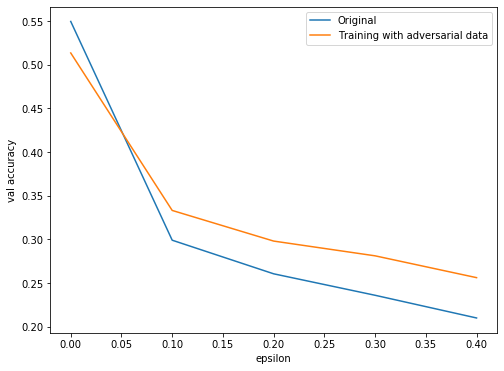

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(eps_vals, np.array(acc_plain), label='Original')
plt.plot(eps_vals, np.array(acc_adv_data), label='Training with adversarial data')
plt.xlabel('epsilon')
plt.ylabel('val accuracy')
plt.legend()
plt.show()

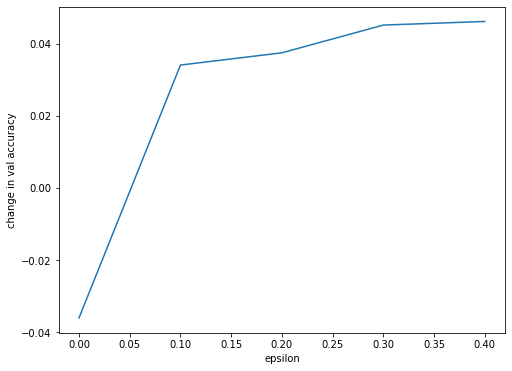

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(eps_vals, np.array(acc_adv_data, dtype=np.float32) - np.array(acc_plain, dtype=np.float32))
plt.xlabel('epsilon')
plt.ylabel('change in val accuracy')
plt.show()

This training method has a smaller decrease in accuracy on clean data while achieving the same accuracy on adversarial examples.

#### Reference:
https://pytorch.org/tutorials/beginner/fgsm_tutorial.html